# Task 7 : Support Vector Machines

All credit for the code examples of this notebook goes to the book "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" by A. Geron. Modifications were made and text was added by K. Zoch ans S. Korn in preparation for the hands-on sessions

## Setup
Let's start by importing a few common modules. You should already be used to this procedure by now.
Again we ensure MatplotLib plots figures inline and prepare a function to save the figures:


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
# This part should be familiar to you
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function to save a figure. This also decides that all output files 
# should stored in the subdirectory 'SVMs'.
PROJECT_ROOT_DIR = "."
EXERCISE = "SVMs"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", EXERCISE)
os.makedirs(IMAGES_PATH, exist_ok=True)

# This should be familiar to you too
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", EXERCISE, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Large margin versus margin violations

The following code example contains two linear support vector machine classifiers ([LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)).
They are initialised with different hyperparameter `C`. The used dataset is the `iris dataset` also shown in the lecture (iris verginica vcs. iris versicolor).
First we want to take a look at the `Hinge` function again, which was introduced in the lecture.  

Afterwards we define different SVMs and investigate them.

In [2]:
# here we quickly investigate the Hinge function
t = np.linspace(-2, 4, 200) #lets define a few example values
h =   # max(0, 1-t) To be implemented using np.where()

#here we put this into a nice plot
plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

SyntaxError: invalid syntax (<ipython-input-2-b330c7fcd897>, line 3)

Remember that the `Hinge` loss function is used for "maximum-margin" classification.

Let's continue with our Tasks from above. We now want to define our SVMs and play with them a little bit.
 Try a few different values for `C` and compare the results! 
What effect do different values of `C` have on:  
(1) the width of the street,  
(2) the number of outliers,  
(3) the number of support vectors?

Saving figure regularization_plot


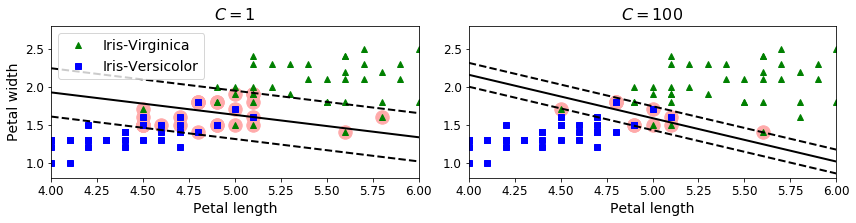

In [18]:
# Here we import some standard libraries again
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Load the dataset and store the necessary features/labels in X/y.
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

# Initialise a scaler and the two SVC instances using the functions imported above
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", max_iter=10000, random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", max_iter=10000, random_state=42)

# Create pipelines to automatically scale the input.
# Do you remember why this is necessary?
scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

# Perform the actual fit of the two models.
# Here We use our well known .fit function that we have used already in the past
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Later we want to plot unscaled parameters
# Therefore we must convert our parameters back to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Now we want to find the support vectors 
# LinearSVC does not do this automatically so we have to do it ourselves
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

# Now we define a function that we will use for plotting
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)
    
# All right! Let's do the plotting!
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])
plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

save_fig("regularization_plot")

To investigate what actually happens under the hood we want to look at this problem in three dimensions.  
The following piece of code produces a 2D and 3D plot that can help you with your understanding of SVMs by visualising the decision function `h` which you already encountered in the lecture.

Saving figure small_w_large_margin_plot


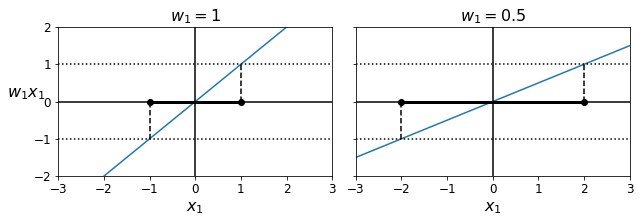

Saving figure iris_3D_plot


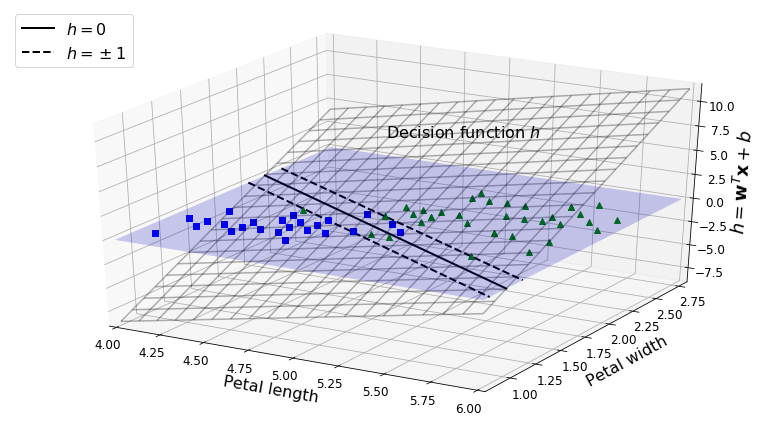

In [26]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

# First we plot a 2D representsation
fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

# And now a 3D representation
fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])
save_fig("iris_3D_plot")
plt.show()

## Polynomial features vs. polynomial kernels

Let's create a non-linear dataset, for which we can compare two approaches:  
(1) adding polynomial features to the model,  
(2) using a polynomial kernel (see exercise sheet).  

First, create some random data. Here you can play around with the `n_samples` and `noise` parameters.

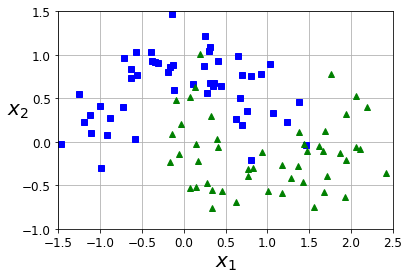

In [19]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.25, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs") # some blue squares
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^") # some green triangles
    plt.axis(axes)
    plt.grid(True, which='both') # to visialize things we add a grid
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

#Let's see how our moon dataset looks like
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Now we will look at a linear SVM classifier that uses polynomial features. We will implement them through a pipeline including scaling of the inputs. 

What happens if you increase the degrees of polynomial features? 
Does the model get better?  
How is the computing time affected? 

**Hint**: you might have to increase the `max_iter` parameter for higher degrees.


Saving figure moons_polynomial_svc_plot


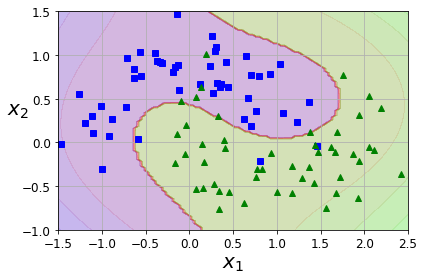

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", max_iter=100e3, random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

Now let's try the same without polynomial features, but a polynomial kernel instead. 

What is the fundamental difference between these two approaches?  
How do they scale in terms of computing time:  
(1) as a function of the number of features,  
(2) as a function of the number of instances?


- Try out different degrees for the polynomial kernel. Do you expect any changes in the computing time? How does the model itself change in the plot?
- Try different values for the coef0 parameter. Can you guess what it controls? You should be able to see different behaviour for different degrees in the kernel.
- Try different values for the hyperparameter C, which controls margin violations.


Saving figure moons_kernelized_polynomial_svc_plot


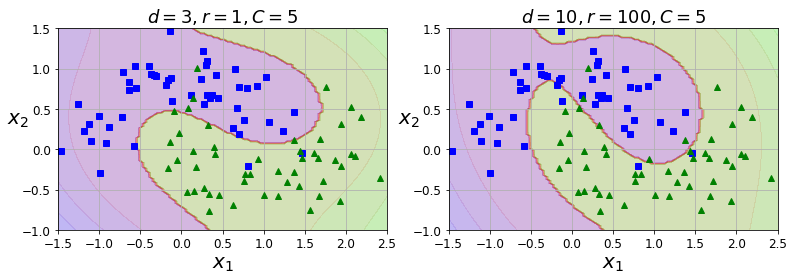

In [8]:
from sklearn.svm import SVC

# Let's make one pipeline with polynomial kernel degree 3.
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

# And another pipeline with polynomial kernel degree 5.
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=5, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

# Now start the plotting.
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)
plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

## Gaussian kernels
Before trying the following piece of code which implements Gaussian RBF (Radial Basis Function) kernels, remember *similarity features* that were discussed in the lecture:

1. What are similarity features? What is the idea of adding a "landmark"?
2. If similarity features help to increase the power of the model, why should we be careful to just add a similarity feature for each instance of the dataset?
3. How does the kernel trick (once again) save the day in this case?
4. What does the gamma parameter control?

Below you find a code implementation which creates a set of four plots with different values for gamma and hyperparameter `C`. Try different values for both. Which direction *increases* regularisation of the model? In which direction would you go to avoid underfitting? In which to avoid overfitting?

Saving figure moons_rbf_svc_plot


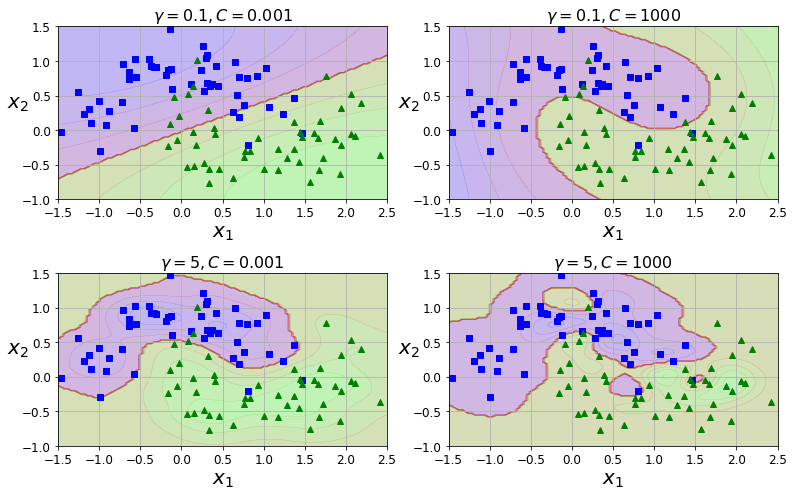

In [9]:
from sklearn.svm import SVC

# Set up multiple values for gamma and hyperparameter C
# and create a list of value pairs.
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

# Store multiple SVM classifiers in a list with these sets of 
# hyperparameters. For all of them, use a pipeline to allow
# scaling of the inputs.
svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

# Now do the plotting.
plt.figure(figsize=(11, 7))
for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

save_fig("moons_rbf_svc_plot")
plt.show()

## Regression
The following code implements the support vector regression class from Scikit-Learn ([SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)). Here are a couple of questions (some of which require changes to the code, others are just conceptual:


1. Quick recap: whereas the SVC class tries to make a classification decision, what is the job of this regression class? How is the output different?
2. Try different values for the hyperparameter C. What does it control?
3. How should the margin of a 'good' SVR model look like? Should it be broad? Should it be narrow? How does the parameter epsilon affect this?


Saving figure svm_with_polynomial_kernel_plot


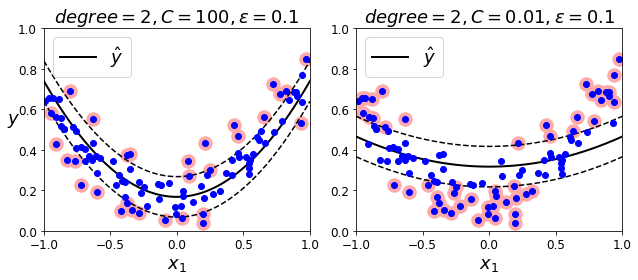

In [16]:
# First we again generate some random data (degree = 2).
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

# Import the support vector regression class and create two 
# instances with different hyperparameters.
from sklearn.svm import SVR
svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="auto")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

# Now do the plotting.
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)
    
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()